## Preprocessing

X_train.shape with outliers: (1460, 80)
(2887, 86)
Index(['SalePrice', 'OverallQual', 'Neighborhood', 'GrLivArea', 'ExterQual',
       'GarageCars', 'KitchenQual', 'BsmtQual', 'GarageArea', 'TotalBath',
       'YearBuilt', 'YearModBooster', 'TotalBsmtSF', 'GarageFinish',
       'FullBath', '1stFlrSF', 'GarageYrBlt', 'YearRemodAdd', 'TotRmsAbvGrd',
       'TotalHouseSize', 'Fireplaces', 'HeatingQC', 'PorchAreaSum',
       'OpenPorchSF', 'MasVnrArea'],
      dtype='object')
Index(['OverallCond', 'ExterCond', 'BsmtFinType2', 'BsmtFinSF2',
       'LowQualFinSF', 'BsmtHalfBath', 'FireplaceQu', '3SsnPorch', 'PoolArea',
       'PoolQC', 'MiscVal', 'HasPool'],
      dtype='object')
(2887, 204)
Train and y have same lenght: True

(1428, 91) 
 (1459, 91) 
 (1428,)


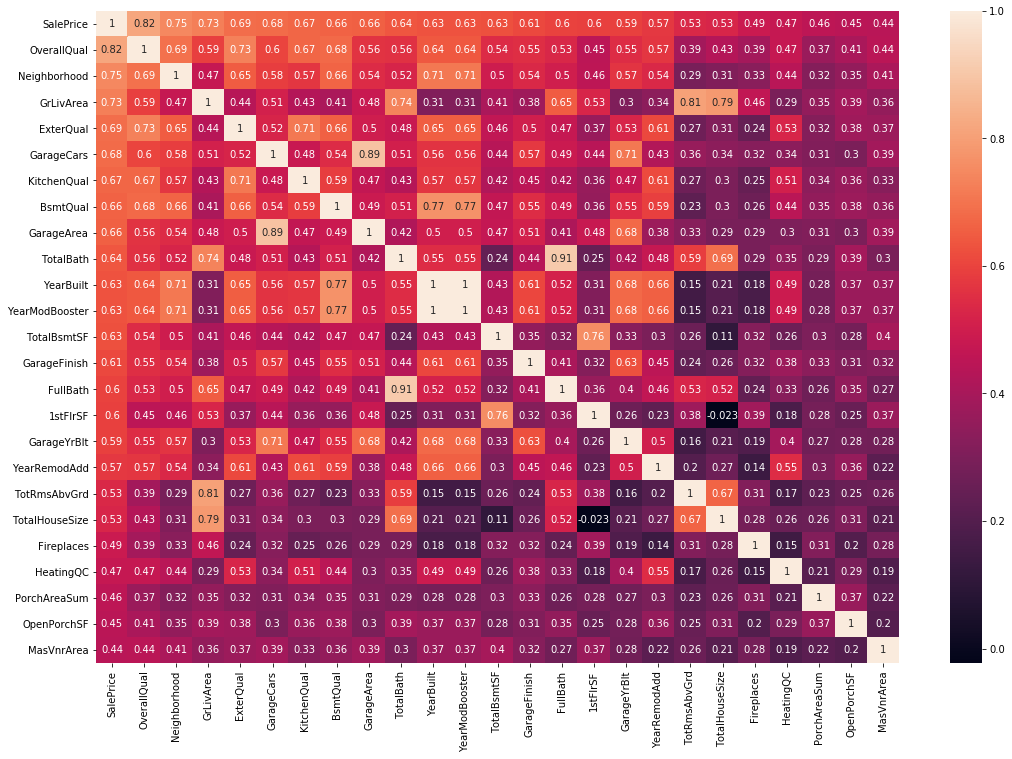

In [10]:
#Load Modules
import numpy as np 
import pandas as pd  
from datetime import datetime

from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax, boxcox

from sklearn.preprocessing import OrdinalEncoder


##############to be removed later########################################
import matplotlib.pyplot as plt 
import seaborn as sns
#######################################################################

#Definitons
numeric_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
neighborhood_ordered = ['MeadowV', 'IDOTRR', 'BrDale', 'BrkSide', 
                        'Edwards', 'OldTown', 'Sawyer', 'Blueste', 
                        'SWISU', 'NPkVill', 'NAmes', 'Mitchel', 'SawyerW', 
                        'NWAmes', 'Gilbert', 'Blmngtn', 'CollgCr', 'Crawfor', 
                        'ClearCr', 'Somerst', 'Veenker', 'Timber', 'StoneBr', 'NridgHt', 
                        'NoRidge']

#VS_loader: Load Data
path = r"..\data\train.csv"
X_train = pd.read_csv(path, index_col= "Id")

path = r"..\data\test.csv"
X_test = pd.read_csv(path, index_col= "Id")

#kaggle path
#X_train = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv', index_col='Id')
#X_test = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv', index_col='Id')

#Drop Id (if not useable)

#Deletion of outliers (GrLiveArea>4500)
print("X_train.shape with outliers: %s" % str(X_train.shape))

X_train = X_train[(X_train["LotFrontage"] <=200) | X_train["LotFrontage"].isna()]
X_train = X_train[(X_train["LotArea"] <= 75000)]
X_train = X_train[(X_train["MasVnrArea"] <=1400) | X_train["MasVnrArea"].isna()]
X_train = X_train[(X_train["BsmtFinSF1"] <=2500)]
X_train = X_train[(X_train["BsmtFinSF2"] <=1200)]
X_train = X_train[(X_train["TotalBsmtSF"] <=3000)]
X_train = X_train[(X_train["1stFlrSF"] <=3000)]
X_train = X_train[(X_train["2ndFlrSF"] <=1750)]
X_train = X_train[(X_train["GrLivArea"] <=4500)]
X_train = X_train[(X_train["BsmtFullBath"] <=2)]
X_train = X_train[(X_train["BsmtHalfBath"] <=1)]
X_train = X_train[(X_train["BedroomAbvGr"] <=6)]
X_train = X_train[(X_train["KitchenAbvGr"] <=2)]
X_train = X_train[(X_train["TotRmsAbvGrd"] <=12) & (X_train["TotRmsAbvGrd"] >=3)]
X_train = X_train[(X_train["GarageArea"] <=1300)]
X_train = X_train[(X_train["WoodDeckSF"] <=800)]
X_train = X_train[(X_train["OpenPorchSF"] <=500)]
X_train = X_train[(X_train["EnclosedPorch"] <=500)]
X_train = X_train[(X_train["MiscVal"] <=6000)]

#print("X_train.shape without outliers: {}".format(X_train.shape))

# Target transformation (log1p inplace)
X_train["SalePrice"] = np.log1p(X_train["SalePrice"])

# Save target in y, drop inX
y = X_train["SalePrice"].reset_index(drop=True)
X_train.drop("SalePrice", axis=1, inplace=True)

#Concat Train + Test
#print(X_train.shape, X_test.shape)
feat = pd.concat([X_train, X_test], ignore_index=True)
#print(feat.shape, "\n")

#Make non numerics which are categories stored as strings and vice versa
num_to_str_cols = ['MSSubClass']
#feat[num_to_str_cols] = feat[num_to_str_cols].apply(lambda x: str(x))
for c in num_to_str_cols:
    feat[c] = feat[c].apply(str)


#Fill categoricals with logical values (medians) (per segment like Garage, Property, etc.)
#print("# of Columns with NaNs: {}".format(len(feat.isna().sum()[feat.isna().sum() > 0])))
#print(feat.isna().sum()[feat.isna().sum() > 0].sort_values(ascending=False))

feat["Alley"] = feat["Alley"].fillna("None")
feat["MasVnrType"] = feat["MasVnrType"].fillna("None")
feat["GarageYrBlt"] = feat["GarageYrBlt"].apply(lambda x: feat["YearBuilt"].index[x.index] if x==None else x)

#Fill other objects with mode and "NA"
mode_fill_cols = ["BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","Electrical","FireplaceQu","Functional"]
NA_fill_cols = ["GarageType","GarageFinish","GarageQual","GarageCond","PoolQC","Fence","MiscFeature"]

for c in mode_fill_cols:
    feat[c] = feat[c].fillna(feat[c].mode()[0])

for c in NA_fill_cols:
    feat[c] = feat[c].fillna("NA")

#Fillthe rest with "None"
for c in feat.select_dtypes(exclude=numeric_types):
    feat[c] = feat[c].fillna("NA")

#Fill numerics with logical values (GrLivArea, LotFrontage)
feat["LotFrontage"]= feat.groupby(["LotShape", "LotConfig","BldgType"])["LotFrontage"].transform(lambda x: x.fillna(x.median()))

#Fill rest of nums with 0
for c in feat.select_dtypes(include=numeric_types).columns:
    feat[c] = feat[c].fillna(0)

#print("# of Columns with NaNs: {}".format(len(feat.isna().sum()[feat.isna().sum() > 0])))
#print(feat.isna().sum()[feat.isna().sum() > 0].sort_values(ascending=False))


#reset index
feat.reset_index(drop=True, inplace=True)

#Measure Skewness and save column names ### Data Leakage
numeric_columns = feat.select_dtypes(include=numeric_types).columns

feature_skewness = feat[numeric_columns].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skewness = feature_skewness[abs(feature_skewness) > 0.5]
skew_transform_index = high_skewness.index

#Transform highly skewed to more normal
for i in skew_transform_index:
    feat[i] = boxcox1p(feat[i], boxcox_normmax(feat[i]+1)) #normmax method="all"

#Generate interessting (boosting) feature combinations (Yearbuild+remod, Porchsize, total sf, total rooms, total baths)
feat["YearModBooster"] = feat["YearBuilt"] + feat["YearRemodAdd"]
feat["TotalHouseSize"] = feat["TotalBsmtSF"] + feat["1stFlrSF"] + feat["2ndFlrSF"]
feat["TotalBath"] = feat["FullBath"] + 0.5 * feat["HalfBath"]
feat["PorchAreaSum"] = feat["WoodDeckSF"] + feat["OpenPorchSF"] + feat["EnclosedPorch"] + feat["3SsnPorch"] + feat["ScreenPorch"]




#Create simplified statements (has pool, garage, 2ndfloor, basement, porch?)
feat["HasBasement"] = feat["TotalBsmtSF"].apply(lambda x: 1 if x > 0 else 0)
feat["HasPool"] = feat["PoolArea"].apply(lambda x: 1 if x > 0 else 0)
feat["Has2nd"] = feat["2ndFlrSF"].apply(lambda x: 1 if x > 0 else 0)
feat["HasGarage"] = feat["GarageArea"].apply(lambda x: 1 if x > 0 else 0)
feat["HasPorch"] = feat["PorchAreaSum"].apply(lambda x: 1 if x > 0 else 0)


#Drop insignificant features (YrSold, MoSold)
drop_cols = ["YrSold", "MoSold"]
feat.drop(drop_cols, axis=1, inplace=True)

#SpecialEncodings

NAPoFaTAGdEx_cols = ["ExterQual","ExterCond","BsmtQual","BsmtCond","HeatingQC","KitchenQual","FireplaceQu","GarageQual","GarageCond","PoolQC"]
_OEncoder = OrdinalEncoder(categories = [["NA", "Po", "Fa", "TA", "Gd", "Ex"]]*len(NAPoFaTAGdEx_cols))
feat[NAPoFaTAGdEx_cols] = pd.DataFrame(_OEncoder.fit_transform(feat[NAPoFaTAGdEx_cols].values ), columns=NAPoFaTAGdEx_cols, index=feat.index)

Other_ordinal_cols = ["BsmtExposure", "BsmtFinType1","BsmtFinType2", "CentralAir", "Electrical", "Functional", "GarageFinish", "Fence", "Neighborhood"]
_OEncoder = OrdinalEncoder(categories = [["NA","No","Mn","Av","Gd"],
                                        ["GLQ","ALQ","BLQ","Rec","LwQ","Unf","NA"],
                                        ["GLQ","ALQ","BLQ","Rec","LwQ","Unf","NA"],
                                        ["N", "Y"],
                                        ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"], 
                                        ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
                                        ["NA", "Unf", "RFn", "Fin"],
                                        ["NA", "MnWw", "GdWo", "MnPrv", "GdPrv"],
                                        neighborhood_ordered] )

feat[Other_ordinal_cols] = pd.DataFrame(_OEncoder.fit_transform(feat[Other_ordinal_cols].values ), columns=Other_ordinal_cols, index=feat.index)



print(feat.shape)


#mapper = {"NA" : 0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5}
#for c in NAPoFaTAGdEx_cols:

#####################################################################TestBay########################
#Drop strongly correlated and insignificants

feat_corr = feat.copy()
feat_corr["SalePrice"] = y
corrmat = feat_corr.corr()
fig, ax = plt.subplots(figsize=(18,12))
#sns.heatmap(corrmat)
highly_correlated_cols = corrmat["SalePrice"].abs().nlargest(25).index
low_correlated_cols =corrmat[corrmat["SalePrice"].abs()<0.1]["SalePrice"].index
print(highly_correlated_cols)
print(low_correlated_cols)

cm2 = corrmat[highly_correlated_cols].T
cm2 = cm2[highly_correlated_cols]

sns.heatmap(cm2, annot=True)

#dropables=["GarageCars","FullBath","YearModBooster", "TotRmsAbvGrd","TotalHouseSize"]#list(low_correlated_cols)

#feat.drop(dropables, axis=1, inplace=True)
#Drop insignificants
####################################################################################################

#Get Dummies
final_feat = pd.get_dummies(feat, drop_first=True).reset_index(drop=True)
print(final_feat.shape)

#Split in Train + test -> Train + Target
X = final_feat.iloc[:len(y), :]
X_test = final_feat.iloc[len(X):, :].set_index(X_test.index, drop=True)
y.reset_index(drop=True)
print("Train and y have same lenght: {}".format(len(X) == len(y)))

#Drop overfitting columns of Train also in test
print()

Overfitter = []
for c in X.columns:
    zeros = len(X[X[c] == 0])
    
    if zeros / len(X) * 100 > 91.6: #99.94:
        Overfitter.append(c)
        
#print(Overfitter)

X = X.drop(Overfitter, axis=1).copy()
X_test = X_test.drop(Overfitter, axis=1).copy()


print(X.shape, "\n", X_test.shape, "\n", y.shape)

In [11]:
#Output section
X["logSalePrice"] = y
X.to_csv(r"..\data\train_preprocessed.csv")
X_test.to_csv(r"..\data\test_preprocessed.csv")






Text(0.5, 1.0, 'Normal Probability Plot')

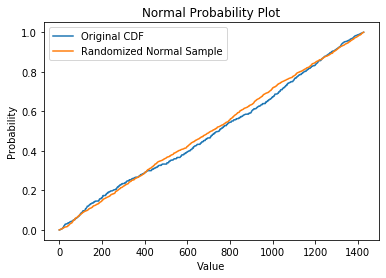

In [25]:
plt.plot(np.sort(norm.cdf(X["logSalePrice"],X["logSalePrice"].mean(), X["logSalePrice"].std())))
plt.plot(np.sort(norm.cdf(np.random.normal(X["logSalePrice"].mean(), X["logSalePrice"].std(),len(X)), X["logSalePrice"].mean(), X["logSalePrice"].std())))
plt.xlabel("Value")
plt.ylabel("Probability")
plt.legend(["Original CDF", "Randomized Normal Sample"])
plt.title("Normal Probability Plot")

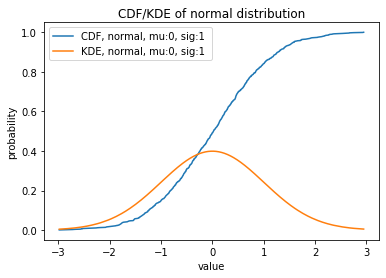

In [26]:
import scipy.stats as stats

sample= np.random.pareto(2,1000)
sample_sorted = sorted(sample)
normal_sample_sorted = sorted(np.random.normal(0,1,len(sample)))
lognormal_sample_sorted = sorted(np.random.lognormal(0,1, len(sample)))
exp_sample_sorted = sorted(np.random.exponential(1,len(sample)))
pareto_sample_sorted = sorted(np.random.pareto(1,len(sample)))


def ecdf(arr):
    return np.sort(arr), np.arange(1, len(arr) +1)/len(arr)

x_sample_cdf, y_sample_cdf = ecdf(sample_sorted)
x_normal_cdf, y_normal_cdf = ecdf(normal_sample_sorted)
x_lognormal_cdf, y_lognormal_cdf = ecdf(lognormal_sample_sorted)
x_exp_cdf, y_exp_cdf = ecdf(exp_sample_sorted)
x_par_cdf, y_par_cdf = ecdf(pareto_sample_sorted)

#plt.plot(x_sample_cdf,y_sample_cdf, marker=".")


plt.plot(x_normal_cdf,y_normal_cdf)
#plt.plot(x_lognormal_cdf, y_lognormal_cdf)
#plt.plot(lognormal_sample_sorted)
plt.plot(normal_sample_sorted , norm.pdf(normal_sample_sorted))
#plt.plot(x_exp_cdf, y_exp_cdf)
#plt.plot(x_par_cdf, y_par_cdf)

#plt.xscale("log")
#plt.yscale("log")
plt.legend(["CDF, normal, mu:0, sig:1 ", "KDE, normal, mu:0, sig:1", ])
plt.xlabel("value")
plt.ylabel("probability")
plt.title("CDF/KDE of normal distribution")
plt.show()

